In [37]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import html
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

In [38]:
pd.set_option('display.max_row', 10)
df = pd.read_csv('../website_classification.csv')
df.tail(10)

,website_url,cleaned_website_text,Category
993,https://wikileaks.org//spyfiles/russia/,wikileaks - spy files russiacontact tor tails ...,Intelligence
994,https://search.wikileaks.org/gifiles/,gi files - contact tor tails tips contact us i...,Intelligence
995,https://wikileaks.org//nsa-201602/,wikileaks - nsa targets world leaders for us g...,Intelligence
996,https://wikileaks.org//cia-france-elections-2012/,wikileaks - cia espionage orders for the frenc...,Intelligence
997,https://wikileaks.org/vault7/#Protego,wikileaks - vault projectscontact tor tails ti...,Intelligence
998,https://wikileaks.org/detaineepolicies/,wikileaks - detainee policiescontact tor tails...,Intelligence
999,https://odin-intelligence.com/,odin intelligenceodin intelligence odin intell...,Intelligence
1000,https://www.auroraintelligence.com/,home page - aurora intelligence aurora intelli...,Intelligence
1001,https://odin-intelligence.com/investigations,investigations odin intelligenceodin intellige...,Intelligence
1002,https://ddosecrets.com/wiki/Distributed_Denial...,distributed denial of secretsdistributed denia...,Intelligence


In [39]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [40]:
def cleaning_text(text):
    text = html.unescape(text)
    text = re.sub(r'[^a-zA-Z0-9\s\'-]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [token for token in tokens if not token.isdigit()]
    cleaned_text = ' '.join(tokens).lower()
    return cleaned_text

In [41]:
def content_generation(website):
    try:
        scrapTool = ScrapTool()
        web = scrapTool.visit_url(website)
        text = cleaning_text(web['website_text'])
        return text
    except Exception as e:
        print('Error: ',website)
        print(e)
        return None

In [43]:
websites = [
    "https://thejavasea.me/threads/meet-your-hot-spicy-threesome-lovers-lifeselector.124651/",
    "https://thejavasea.me/threads/hype3d-collection-2023.126095/",
    "https://thejavasea.me/threads/nsfw-natural-selection-female-wrestling-final-nsfw-gamer.117940/",
    "https://readysetcam.com/blogs/camming-101/best-cam-sites#onlyfans",
    "https://chaturbate.com/female-cams/?join_overlay=1&tour=IsSO&campaign=teJSS&disable_sound=0",
    "https://www.slutroulettecam.com/?AFNO=1-86683-1025be3590b0568ed71e77c52058c3&form=10",
    "https://imlive.com/live-sex-chats/cam-girls/video-chats/AryaHuntt/",
    "https://tour.camsoda.com/resp-t7/?id=corvelaymedia&type=PPS&noterms=1&u4=best",
    "https://www.xcams.com/",
    "https://www.streamate.com/?%3Flangchoice=en"
]

for website in websites:
    try:
        content = content_generation(website)
        print(content)
        content_list = [website,content,"Adult"]
        df.loc[len(df)] = content_list
    except Exception as e:
        print(website,": ",e)


meet your hot spicy threesome lovers lifeselector thejavasea - technology worldmeet your hot spicy threesome lovers lifeselector released -april- genre pov hardcore lesbian latina toys titjob doggy meet your hot spicy threesome lovers lifeselectorsearch meet your hot spicy threesome lovers lifeselector gamergirls menu forums upgrade to vip new posts search forums what's new new posts new resources new profile posts latest activity vip upgrade vip resources rules resources latest reviews search resources members registered members current visitors new profile posts search profile posts log in register what's new search everywhere threads this forum this thread search titles only by search advanced search upgrade to vip new posts search forums menu log in register install the app install forums latest technology network hacks hacking leaks proxies other leaks javascript is disabled for a better experience please enable javascript in your browser before proceeding meet your hot spicy thre

In [44]:
df['Category'].value_counts()

Computers and Technology           302
Social Networking and Messaging    114
Business/Corporate                 106
E-Commerce                         101
News                                93
                                  ... 
Narcotics                           74
Adult                               51
Financial Crime                     40
Intelligence                        33
Forums                              16
Name: Category, Length: 11, dtype: int64

In [45]:
df[df["Category"]=="Intelligence"]

,website_url,cleaned_website_text,Category
970,http://www.csrc.gov.cn/csrc_en/c102023/common_...,overviewaboutmaintain a transparent fair and e...,Intelligence
971,http://www.jar2.com/Files/Lists/NSA_List.html,nsa employee directory nsa list employee archi...,Intelligence
972,https://ddosecrets.com/index.php?title=Hunter_...,hunter biden laptop - distributed denial of se...,Intelligence
973,https://ddosecrets.com/wiki/About,about - distributed denial of secretsabout con...,Intelligence
974,https://ddosecrets.com/index.php?title=Distrib...,distributed denial of secrets difference betwe...,Intelligence
...,...,...,...
998,https://wikileaks.org/detaineepolicies/,wikileaks - detainee policiescontact tor tails...,Intelligence
999,https://odin-intelligence.com/,odin intelligenceodin intelligence odin intell...,Intelligence
1000,https://www.auroraintelligence.com/,home page - aurora intelligence aurora intelli...,Intelligence
1001,https://odin-intelligence.com/investigations,investigations odin intelligenceodin intellige...,Intelligence


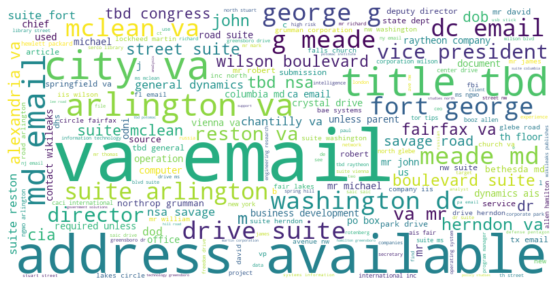

In [52]:
from wordcloud import WordCloud

category_name = "Intelligence"
category_data = df[df["Category"]==category_name]['cleaned_website_text']
category_text = ' '.join(category_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

important_words = wordcloud.words_.keys()


In [47]:
important_words = ["none","phone","fax"]

df.loc[df["Category"]=="Intelligence","cleaned_website_text"] = df.loc[df["Category"]=="Intelligence","cleaned_website_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in important_words]))

In [49]:
df.reset_index(drop=True, inplace=True)

In [51]:
df.to_csv("website_classification.csv",index=False)
# computers.to_csv("../Hierarchal model/Computer/computer_subcategory_classification.csv",index=False)